***Uso de Machine Learning para la Mejora del Análisis de Reseñas de
Clientes en Plataformas de Comercio Electrónico***

**Asignatura: Seminario de Investigación**

**Presentado por: Diego Benavides**

In [139]:
#Importar librerías
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter

# Descargar recursos de nltk si no están
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [141]:
#Cargar datos
df = pd.read_csv('../Datos/Reviews.csv', encoding='ISO-8859-1', low_memory=False)

**Se filtran los datos por las columnas de interés para el desarrollo del modelo**

In [143]:
# Seleccionar las columnas necesarias
df = df[['name', 'reviews.rating', 'reviews.text']].dropna()

# Asegurarque las calificaciones sean numéricas y dentro del rango 1-5
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')
df = df[df['reviews.rating'].isin([1, 2, 3, 4, 5])]

# Filtrar reseñas claramente positivas o negativas (excluimos las neutras = 3)
df = df[df['reviews.rating'] != 3]

# Creamos la columna de sentimiento
df['sentimiento'] = df['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)

# Mostramos una muestra
df.head()


,name,reviews.rating,reviews.text,sentimiento
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",5.0,This product so far has not disappointed. My c...,1
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",5.0,great for beginner or experienced person. Boug...,1
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",5.0,Inexpensive tablet for him to use and learn on...,1
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",4.0,I've had my Fire HD 8 two weeks now and I love...,1
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",5.0,I bought this for my grand daughter when she c...,1


Determinar si existen desbalances

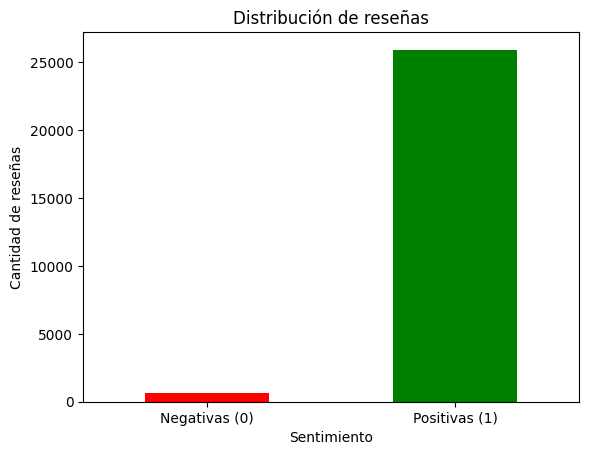

In [145]:
# Conteo de reseñas positivas y negativas
conteo_sentimientos = df['sentimiento'].value_counts().sort_index()

# Usar color en el orden correcto: 0 = negativo (rojo), 1 = positivo (verde)
conteo_sentimientos.plot(kind='bar', color=['red', 'green'])

plt.title('Distribución de reseñas')
plt.xticks(ticks=[0, 1], labels=['Negativas (0)', 'Positivas (1)'], rotation=0)
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de reseñas')
plt.show()


Nota: Existe un desbalanceo en los datos, por lo que se procede a balancear el dataset

In [147]:
from sklearn.utils import resample

# Separar clases
positivas = df[df['sentimiento'] == 1]
negativas = df[df['sentimiento'] == 0]

# Submuestreo de la clase mayoritaria (positivas)
positivas_balanceadas = resample(positivas,
                                 replace=False,     # sin reemplazo
                                 n_samples=len(negativas),  # igualar cantidad
                                 random_state=42)

# Unir ambas clases balanceadas
df_balanceado = pd.concat([negativas, positivas_balanceadas])

# Mezclar el dataset
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar
print(df_balanceado['sentimiento'].value_counts())


sentimiento
1    665
0    665
Name: count, dtype: int64


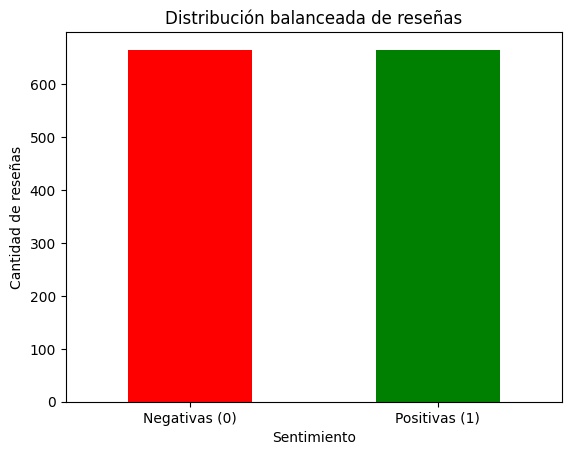

In [149]:
#Gráfico post balance
conteo_balanceado = df_balanceado['sentimiento'].value_counts().sort_index()
conteo_balanceado.plot(kind='bar', color=['red', 'green'])

plt.title('Distribución balanceada de reseñas')
plt.xticks(ticks=[0, 1], labels=['Negativas (0)', 'Positivas (1)'], rotation=0)
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de reseñas')
plt.show()


Preprocesamiento del texto

Esto busca lograr lo siguiente:

- Poner todo en minúsculas
- Eliminar signos de puntuación y números
- Eliminar stopwords (palabras vacías)
- Tokenizar y lematizar

In [151]:
import re
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Inicializamos stopwords y lematizador
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto(texto):
    if not isinstance(texto, str):
        return ""

    # Minúsculas
    texto = texto.lower()

    # Eliminar etiquetas HTML, signos, números, etc.
    texto = re.sub(r'<[^>]+>', ' ', texto)  # eliminar HTML
    texto = re.sub(r'[^a-z\s]', ' ', texto)  # solo letras
    texto = re.sub(r'\s+', ' ', texto)  # espacios múltiples

    # Tokenización segura
    tokens = wordpunct_tokenize(texto)

    # Stopwords y lematización
    tokens_limpios = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]

    return ' '.join(tokens_limpios)



In [153]:
df_balanceado['texto_limpio'] = df_balanceado['reviews.text'].apply(limpiar_texto)

# Aplicamos la función de limpieza
df_balanceado['texto_limpio'] = df_balanceado['reviews.text'].apply(limpiar_texto)

# Verificamos los resultados
df_balanceado[['reviews.text', 'texto_limpio']].head()


,reviews.text,texto_limpio
0,I love the features and works great! Perfect g...,love feature work great perfect gift occasion
1,Best tablet and most affortable. Love that it ...,best tablet affortable love work must prime
2,Our daughter loves the size and portability of...,daughter love size portability product ipad di...
3,Bought the tablets for my kids. The tablet isn...,bought tablet kid tablet really friendly home ...
4,"If you actually paid 20 for this adapter, you'...",actually paid adapter mind


Vectorización con TF-IDF

- Esto busca convertir texto en vectores numéricos útiles para modelos de machine learning.

Importante:


- max_features=5000: limita el número de palabras a las 5000 más frecuentes para evitar vectores muy grandes.

- fit_transform(...): ajusta el vectorizador al texto y lo transforma a una matriz esparsa.

- toarray(): convierte la matriz esparsa en una matriz densa para poder visualizarla fácilmente.

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creamos el vectorizador
vectorizador = TfidfVectorizer(max_features=5000)  # puedes ajustar este número si deseas

# Ajustamos y transformamos el texto
X_vectores = vectorizador.fit_transform(df_balanceado['texto_limpio'])

# Convertimos a un DataFrame para inspección si se desea
X_vectores_df = pd.DataFrame(X_vectores.toarray(), columns=vectorizador.get_feature_names_out())

# Mostramos algunas columnas y filas
X_vectores_df.head()


,abc,ability,able,abruptly,absolute,absolutely,abuse,ac,accedently,accent,...,yo,york,young,younger,youngest,youngster,youtube,yr,yuh,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.233053,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Nota:

Cada fila representa una reseña, y cada columna una palabra (o término) entre las 5000 más importantes del corpus. Los valores son pesos TF-IDF: reflejan qué tan relevante es una palabra en una reseña, comparada con todas las demás.

División en conjuntos de entrenamiento y prueba

In [157]:
from sklearn.model_selection import train_test_split

# Definimos variables
X = X_vectores
y = df_balanceado['sentimiento']  # o el nombre correcto de tu columna objetivo

# División 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificamos tamaños
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (1064, 3114)
Tamaño del conjunto de prueba: (266, 3114)


Entrenamiento del modelo

In [159]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Inicializamos y entrenamos el modelo
modelo_nb = MultinomialNB()
modelo_nb.fit(X_train, y_train)

# Predicciones
y_pred = modelo_nb.predict(X_test)

# Evaluación del modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.849624060150376

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       133
           1       0.83      0.89      0.86       133

    accuracy                           0.85       266
   macro avg       0.85      0.85      0.85       266
weighted avg       0.85      0.85      0.85       266


Confusion Matrix:
 [[108  25]
 [ 15 118]]


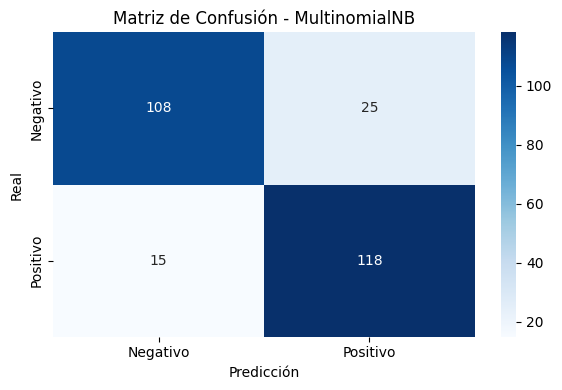

In [161]:

from sklearn.metrics import ConfusionMatrixDisplay

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Gráfico con Seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - MultinomialNB')
plt.tight_layout()
plt.show()


**Evaluación del modelo**

- Exactitud (Accuracy): 0.85

Esto indica que el modelo acertó en el 85% de los casos, lo cual es un desempeño sólido, especialmente para datos textuales.

- Reporte de Clasificación:

Clase 0 (negativa o no positiva):

Precision: 0.88 → muy pocas veces predijo “negativa” cuando era otra cosa.

Recall: 0.81 → detectó correctamente el 81% de las reseñas negativas.

Clase 1 (positiva):

Precision: 0.83

Recall: 0.89 → muy buena recuperación de los positivos.

Resumen de la evaluación:

- 108 negativos bien clasificados.

- 118 positivos bien clasificados.

- 25 falsos positivos.

- 15 falsos negativos.


In [165]:
import pickle
import os

# Crea la carpeta si no existe
os.makedirs("Reviews_Seminario", exist_ok=True)

# Guarda el vectorizador
with open("Reviews_Seminario/vectorizador.pkl", "wb") as f:
    pickle.dump(vectorizador, f)

# Guarda el modelo entrenado
with open("Reviews_Seminario/modelo_naive_bayes.pkl", "wb") as f:
    pickle.dump(modelo_nb, f)

print("✅ Modelo y vectorizador guardados correctamente.")



✅ Modelo y vectorizador guardados correctamente.
